In [0]:
# basic libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# for data
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

**Device: CUDA or CPU**

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ', device)

Device:  cuda:0


**Download datasets & transform**

In [78]:
data_transform = transforms.ToTensor()

train_data = FashionMNIST('./data', train=True, download=True, transform=data_transform)

test_data = FashionMNIST('./data', train=False, download=True, transform=data_transform)

print('Train data images: {}'.format(len(train_data)))
print('Test data images: {}'.format(len(test_data)))

Train data images: 60000
Test data images: 10000


**Prepare data loaders & batch size**

In [0]:
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

**Visualize training data**

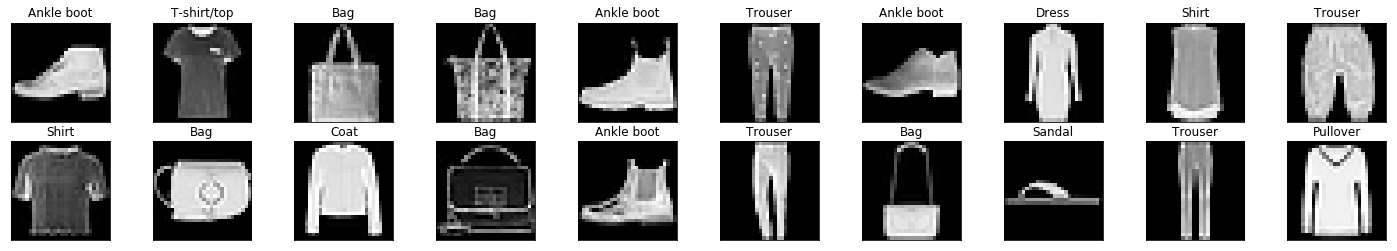

In [80]:
# get one batch of data
dataiter = iter(train_loader)
images, labels = dataiter.next()

images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(classes[labels[idx]])
  

**Define a network architecture**

In [111]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 10, 3)
    
    self.pool = nn.MaxPool2d(2,2)
    
    self.conv2 = nn.Conv2d(10, 20, 3)
    
    self.fc1 = nn.Linear(20*5*5, 50)
    
    self.fc1_drop = nn.Dropout(p=0.4)
    
    self.fc2 = nn.Linear(50, 10)
    
  def forward(self, x):

    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    
    # flatten
    x = x.view(x.size(0), -1)
    
    x = F.relu(self.fc1(x))
    x = self.fc1_drop(x)
    x = self.fc2(x)
    
    return x
  
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


**Loss and optimizer functions**

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**Calculate accuracy before training**

In [0]:
def check_accuracy(mynet):
  mynet.eval()
  correct = 0
  total = 0
  accuracy = 0
  
  for images, labels in test_loader:

    images = images.to(device)
    labels = labels.to(device)
    
    outputs = mynet.forward(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

  accuracy = 100.0 * correct.item() / total
  return accuracy

In [114]:
check_accuracy(net)

9.87

**Train the network**

1. Zero's the gradients to prepare for a forward pass
2. Passes the input through the network (forward pass)
3. Computes the loss (how far is the predicted classes are from the correct labels)
4. Propagates gradients back into the network’s parameters (backward pass)
5. Updates the weights (parameter update)
6. Prints out the calculated loss

In [0]:
import time

def train(n_epochs):

  #net.train()
  
  loss_over_time = []
  
  for epoch in range(n_epochs):
    start_time = time.time()
    
    running_loss = 0.0
    
    for batch_i, data in enumerate(train_loader):
      
      inputs, labels = data
      
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      
      outputs = net(inputs)
      
      loss = criterion(outputs, labels)
      
      loss.backward()
      
      optimizer.step()
      
      running_loss += loss.item()
      
      if batch_i % 1000 == 999:
        avg_loss = running_loss/1000
        loss_over_time.append(avg_loss)
        print('Epoch: {}, Batch: {}, Avg Loss: {}'.format(epoch, batch_i, avg_loss))
        running_loss = 0.0
    print('\n==============\nEpoch: {}, Accuracy: {} -- Time taken: {}\n==============\n'.format(epoch, check_accuracy(net), (time.time() - start_time)))
    

  print('Finished training')
  
  # Plot loss function
  plt.plot(loss_over_time)
  plt.xlabel('1000\'s of batches')
  plt.ylabel('loss')
  plt.ylim(0, 2.5) # consistent scale
  plt.show()
  
  return loss_over_time

Epoch: 0, Batch: 999, Avg Loss: 1.593055670440197
Epoch: 0, Batch: 1999, Avg Loss: 0.8127242347598076
Epoch: 0, Batch: 2999, Avg Loss: 0.7120248521417379

Epoch: 0, Accuracy: 74.44 -- Time taken: 11.27447247505188

Epoch: 1, Batch: 999, Avg Loss: 0.623988684207201
Epoch: 1, Batch: 1999, Avg Loss: 0.5836579077541828
Epoch: 1, Batch: 2999, Avg Loss: 0.5335725409388542

Epoch: 1, Accuracy: 79.55 -- Time taken: 11.258339643478394

Epoch: 2, Batch: 999, Avg Loss: 0.5075214056745172
Epoch: 2, Batch: 1999, Avg Loss: 0.4924737182110548
Epoch: 2, Batch: 2999, Avg Loss: 0.47092015286535027

Epoch: 2, Accuracy: 81.61 -- Time taken: 11.206984519958496

Epoch: 3, Batch: 999, Avg Loss: 0.44488633931428195
Epoch: 3, Batch: 1999, Avg Loss: 0.43723962269723415
Epoch: 3, Batch: 2999, Avg Loss: 0.42274259513244034

Epoch: 3, Accuracy: 83.8 -- Time taken: 11.25380539894104

Epoch: 4, Batch: 999, Avg Loss: 0.41143379304558036
Epoch: 4, Batch: 1999, Avg Loss: 0.3949633652791381
Epoch: 4, Batch: 2999, Avg Lo

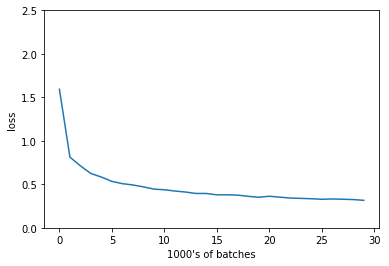

In [116]:
training_loss = train(10)

**Saving the model**

In [0]:
model_dir = 'saved_models/'
model_name = 'fashion_net_ex.pt'

torch.save(net.state_dict(), model_name)

**Load saved model and predict**

In [118]:
loaded_model = Net()
loaded_model = loaded_model.to(device)
loaded_model.load_state_dict(torch.load(model_name))

loaded_model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [119]:
check_accuracy(loaded_model)

87.51